Dimer with Kanamori interaction
=======

We calculate the Green function of a dimer coupled with Kanamori interaction and a coupling to discrete bath states.

The non-interacting hamiltonian is most conveniently expressed using a matrix representation

$$
\hat{h} =
\begin{pmatrix}
\hat{h}_{0} & \hat{h}_{\rm coup} \\
\hat{h}_{\rm coup} & \hat{h}_{\rm bath}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
\epsilon_0 -\mu & -t \\
-t & \epsilon_1 -\mu
\end{pmatrix} & 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\\
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix} & 
\begin{pmatrix}
\epsilon_{0,{\rm bath}} & -t_{\rm bath} \\
-t_{\rm bath} & \epsilon_{1,{\rm bath}}
\end{pmatrix}
\end{pmatrix}
$$

The impurity interaction is of the Kanamori-type, and reads

$$h_{\rm int} = \sum_{i,j} U n_{\uparrow,i} n_{\downarrow,j} + \sum_{\sigma,i\neq j} U' n_{\sigma,i} n_{\sigma,j}
            - \sum_{i \neq j} J c^\dagger_{i \uparrow} c_{i \downarrow} c^\dagger_{j \downarrow} c_{j \uparrow}
            + \sum_{i \neq j} J c^\dagger_{i \uparrow} c^\dagger_{i \downarrow} c_{j \downarrow} c_{j \uparrow}$$
   
The parameters are defined below.

In [1]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from triqs.operators import c, c_dag, n
from triqs.operators.util import h_int_kanamori, U_matrix_kanamori
from itertools import product
from numpy import matrix, array, block, diag, eye
from numpy.linalg import inv

from math import sqrt

# ==== System Parameters ====
beta = 16.                      # Inverse temperature
mu = 0.0                        # Chemical potential
eps = array([0.0, 0.0])         # Impurity site energies
t = 0.0                         # Hopping between impurity sites

eps_bath = array([-2.3, 2.3])  # Bath site energies
t_bath = 0.0                       # Hopping between bath sites

U = 2                         # Density-density interaction
J = 0.2                       # Hunds coupling

spin_names = ['up', 'dn']
orb_names  = [0, 1]
n_orb = len(orb_names)

# Non-interacting impurity hamiltonian in matrix representation
h_0_mat = diag(eps - mu) - matrix([[0, t],
                                   [t, 0]])

# Bath hamiltonian in matrix representation
h_bath_mat = diag(eps_bath) - matrix([[0, t_bath],
                                      [t_bath, 0]])

# Coupling matrix
r = 0.5
V_mat = 1. / 2. * matrix([[sqrt(1+r) + sqrt(1-r), sqrt(1+r) - sqrt(1-r)],
                          [sqrt(1+r) - sqrt(1-r), sqrt(1+r) + sqrt(1-r)]])
# V_mat * V_mat.T = a * [[ 1,  r ],
#                        [ r,  1 ]]

# ==== Local Hamiltonian ====
c_dag_vec = { s: matrix([[c_dag(s,o) for o in orb_names]]) for s in spin_names }
c_vec =     { s: matrix([[c(s,o)] for o in orb_names]) for s in spin_names }

h_0 = sum(c_dag_vec[s] * h_0_mat * c_vec[s] for s in spin_names)[0,0]

## h_int_kanamori includes also pair-hopping terms! Not considered in Edelstein Paper
#Umat, Upmat = U_matrix_kanamori(n_orb, U_int=U, J_hund=J)
#h_int = h_int_kanamori(spin_names, orb_names, Umat, Upmat, J, off_diag=True)
h_int = U * (n('up', 0) * n('dn', 0) + n('up', 1) * n('dn', 1)) \
     + (U - 2*J) * (n('up', 0) * n('dn', 1) + n('up', 1) * n('dn', 0)) \
     + (U - 3*J) * (n('up', 0) * n('up', 1) + n('dn', 0) * n('dn', 1)) \
     + J * c_dag('up', 0) * c_dag('dn', 1) * c('dn', 0) * c('up', 1) \
     + J * c_dag('up', 1) * c_dag('dn', 0) * c('dn', 1) * c('up', 0)

h_imp = h_0 + h_int

# ==== Bath & Coupling hamiltonian ====
orb_bath_names = [n_orb + o for o in orb_names]
c_dag_bath_vec = { s: matrix([[c_dag(s, o) for o in orb_bath_names]]) for s in spin_names }
c_bath_vec =     { s: matrix([[c(s, o)] for o in orb_bath_names]) for s in spin_names }

h_bath = sum(c_dag_bath_vec[s] * h_bath_mat * c_bath_vec[s] for s in spin_names)[0,0]
h_coup = sum(c_dag_vec[s] * V_mat * c_bath_vec[s] + c_dag_bath_vec[s] * V_mat * c_vec[s] for s in spin_names)[0,0] # FIXME Adjoint

# ==== Total impurity hamiltonian ====
h_tot = h_imp + h_coup + h_bath

# ==== Green function structure ====
# gf_struct = [ [s, orb_names] for s in spin_names ]
gf_struct = [ [s, n_orb] for s in spin_names ]

# ==== Non-Interacting Impurity Green function  ====
n_iw = int(10 * beta)
#n_tau = 2 * n_iw + 1
n_tau = 20
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
tau_mesh = MeshImTime(beta, 'Fermion', n_tau)
G0_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
h_tot_mat = block([[h_0_mat, V_mat     ],
                   [V_mat.H, h_bath_mat]])
for bl, iw in product(spin_names, iw_mesh):
    G0_iw[bl][iw] = inv(iw.value * eye(2*n_orb) - h_tot_mat)[:n_orb, :n_orb]

# ==== Hybridization Function ====
Delta = G0_iw.copy()
Delta['up'] << iOmega_n - h_0_mat - inverse(G0_iw['up'])
Delta['dn'] << iOmega_n - h_0_mat - inverse(G0_iw['dn'])


Greens Function G_dn with mesh Matsubara Freq Mesh of size 320, Domain: Matsubara domain with beta = 16, statistic = 1, positive_only : 0 and target_rank 2: 

In [2]:
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

from triqs.plot.mpl_interface import oplot, plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
#matplotlib.rc('text', usetex=True)

from triqs.atom_diag import *
from triqs.utility.redirect import *

from inchworm.ad_tools import *

import numpy as np

Starting run with 1 MPI rank(s) at : 2020-12-21 17:27:18.898816


In [3]:
fop_imp = [(s,o) for s,o in product(spin_names, orb_names)]
fop_bath = [(s,o) for s,o, in product(spin_names, orb_bath_names)]
fop_tot = fop_imp + fop_bath

eff_hyb = create_effective_hyb(gf_struct)

ad_imp = AtomDiag(h_imp, eff_hyb, fop_imp)
ad_bath = AtomDiag(h_bath, fop_bath)
ad_tot = AtomDiag(h_tot, fop_tot)

In [4]:
from triqs.operators import Operator 

n_tau_inch = 100
u_exact = make_ED_propagator(ad_tot, ad_imp, ad_bath, beta, n_tau_inch)
tau_mesh = u_exact['0'].mesh

u_bare = make_ED_propagator(ad_imp, ad_imp, AtomDiag(Operator(), []), beta, n_tau_inch)

In [5]:
with HDFArchive('results/inchworm.h5', 'r') as arch:
    u_inch = arch['Solver_Info']['solver'].u_tau

In [6]:
def get_frame(u, tau):
    return np.array([u[bl][tau] for bl in u.indices], dtype=object)

def norm(frame):
    #return max(np.linalg.norm(frame_bl) for frame_bl in frame)
    flat = np.concatenate([frame_bl.flatten() for frame_bl in frame])
    return np.linalg.norm(flat)

u_exact_norm = np.array([norm(get_frame(u_exact, tau)) for tau in tau_mesh])
u_inch_norm = np.array([norm(get_frame(u_inch, tau)) for tau in tau_mesh])
u_bare_norm = np.array([norm(get_frame(u_bare, tau)) for tau in tau_mesh])
u_diff_norm = np.array([norm(get_frame(u_inch - u_exact, tau)) for tau in tau_mesh])

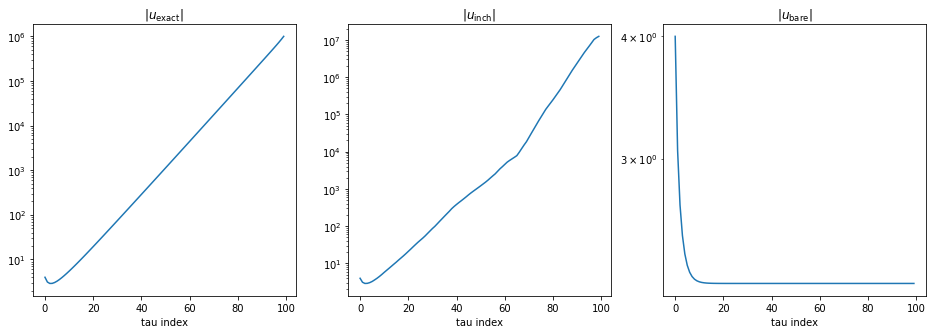

In [7]:
plt.subplots(1, 3, figsize=(16,5))

plt.subplot(1, 3, 1)
plt.plot(u_exact_norm)
plt.title(r'$|u_{\rm exact}|$')
plt.xlabel('tau index')
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.plot(u_inch_norm)
plt.title(r'$|u_{\rm inch}|$')
plt.xlabel('tau index')
plt.yscale('log')

plt.subplot(1, 3, 3)
plt.plot(u_bare_norm)
plt.title(r'$|u_{\rm bare}|$')
plt.xlabel('tau index')
plt.yscale('log')

Text(0.5, 0, 'tau index')

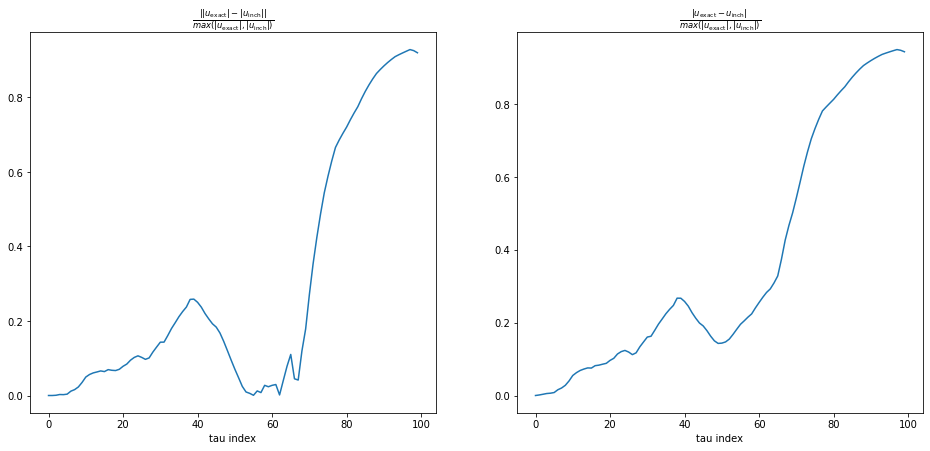

In [8]:
plt.subplots(1, 2, figsize=(16,7))

plt.subplot(1, 2, 1)
plt.plot(np.abs(u_exact_norm - u_inch_norm) / np.maximum(u_exact_norm, u_inch_norm))
#plt.plot(np.abs(u_exact_norm - u_inch_norm))
#plt.yscale('log')
plt.title(r'$\frac{||u_{\rm exact}| - |u_{\rm inch}||}{max(|u_{\rm exact}|, |u_{\rm inch}|)}$')
plt.xlabel('tau index')

plt.subplot(1, 2, 2)
plt.plot(u_diff_norm / np.maximum(u_exact_norm, u_inch_norm))
#plt.plot(u_diff_norm)
#plt.yscale('log')
plt.title(r'$\frac{|u_{\rm exact} - u_{\rm inch}|}{max(|u_{\rm exact}|, |u_{\rm inch}|)}$')
plt.xlabel('tau index')

In [9]:
from inchworm import *
start_redirect()

from h5 import HDFArchive

with HDFArchive('results/inchworm.h5', 'r') as arch:
    S = arch['Solver_Info']['solver']
    
cp = S.constr_params

sp = S.last_solve_params
sp['verbosity'] = 4
sp['measure_order_histogram'] = True
sp['n_cycles'] = 500000

u_exact = make_ED_propagator(ad_tot, ad_imp, ad_bath, beta, cp['n_tau_inch'])
qmc_res = S.solve_self_consistently(sp, u_exact, 0.9 * cp['beta'], cp['beta'])

print(qmc_res.order_histogram)

[4.85004e-01 3.07790e-01 1.44834e-01 4.57000e-02 1.28140e-02 3.03000e-03
 7.90000e-04 2.60000e-05 1.20000e-05 0.00000e+00]


In [10]:
#print(qmc_res.frame_0th_order)
print(qmc_res.order_histogram)

[4.85004e-01 3.07790e-01 1.44834e-01 4.57000e-02 1.28140e-02 3.03000e-03
 7.90000e-04 2.60000e-05 1.20000e-05 0.00000e+00]


In [11]:
print(qmc_res.frame)

[array([[285598.90085349]])
 array([[ 34291.03637703,  41501.08386822],
       [ 44098.84034807, 669164.3772832 ]])
 array([[ 34243.37560816,  47297.67823083],
       [ 44054.4421948 , 662285.06131352]])
 array([[38653.43246242]])
 array([[44310.05247497, -5392.5593664 ,  -403.13213133,  -714.63896409],
       [-4622.83129078, 41066.03567679,  3917.11071243, 12648.40517997],
       [  -95.79758531,  5003.83236296,  3224.63414848,  1334.26918617],
       [ 1683.98675494, 11234.15278129,  1119.22587544,  3717.2250626 ]])
 array([[44569.10219006]])
 array([[1915.97456784,  498.80555442],
       [ 601.9938428 ,  195.54128803]])
 array([[1690.63644552,  337.64768204],
       [ 412.69423447,  102.80185661]])
 array([[0.00260518]])]


In [12]:
u_frame_exact = get_frame(u_exact, Idx(cp['n_tau_inch'] - 1))
print(u_frame_exact)

[array([[303503.95823245]])
 array([[ 33556.44405155,  45153.89588628],
       [ 45153.89588628, 666571.43007595]])
 array([[ 33556.44405155,  45153.89588627],
       [ 45153.89588627, 666571.43007592]])
 array([[39525.06410828]])
 array([[ 3.95250641e+04, -7.71251507e-10, -6.98037184e-11,
        -3.19232640e-10],
       [-7.71251507e-10,  3.60591138e+04,  3.79580023e+03,
         1.39304503e+04],
       [-7.00310920e-11,  3.79580023e+03,  2.23523330e+03,
         1.31584549e+03],
       [-3.18323146e-10,  1.39304503e+04,  1.31584549e+03,
         5.39405163e+03]])
 array([[39525.06410828]])
 array([[1456.31444287,  415.03288267],
       [ 415.03288267,  118.28155524]])
 array([[1456.31444287,  415.03288267],
       [ 415.03288267,  118.28155524]])
 array([[4.90237781e-05]])]


In [13]:
print([frobenius_norm(u_bl) / frobenius_norm(u_bl)])

NameError: name 'frobenius_norm' is not defined